In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from torch.utils.data import DataLoader
from datasets import Dataset
import torch
import seaborn as sns
sns.set(style='whitegrid', palette='Set2')

# Данные

In [3]:
df_train = pd.read_csv('/kaggle/input/vk-dataset/train_spam.csv')
df_test = pd.read_csv('/kaggle/input/vk-dataset/test_spam.csv')
df_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Закодируем лейблы для удобства

In [4]:
label2id = {'ham': 0,
           'spam': 1}

In [5]:
df_train['text_type'] = df_train['text_type'].map(label2id) 

Посмотрим на примеры текстов

In [6]:
df_train.sample(20)

,text_type,text
2788,0,then ur physics get a
16181,0,what are you doing in langport sorry but ill p...
4003,0,thats why i will suggest that to you
11689,0,i was sleeping o oh! i forgot o / to say you o...
10989,0,welcome to pjm customer info welcome to the pj...
6576,0,i might have a chance in tcs for internship da...
7507,0,hmph go head big baller
7430,1,gr8 poly tones 4 all mobs direct 2u rply with ...
12416,1,with the sudden dip in crypto currency prices ...
6810,0,on thu sep 1635465 1635465 at 1635465 1635465 ...


Тексты довольно разнообразные, могут включать эмоджи. Также текст может быть наклонным и выделен жирным шрифтом. Это намекает на то, что датасет взят из соцсетей или мессенджеров

Посмотрим на распределение длин

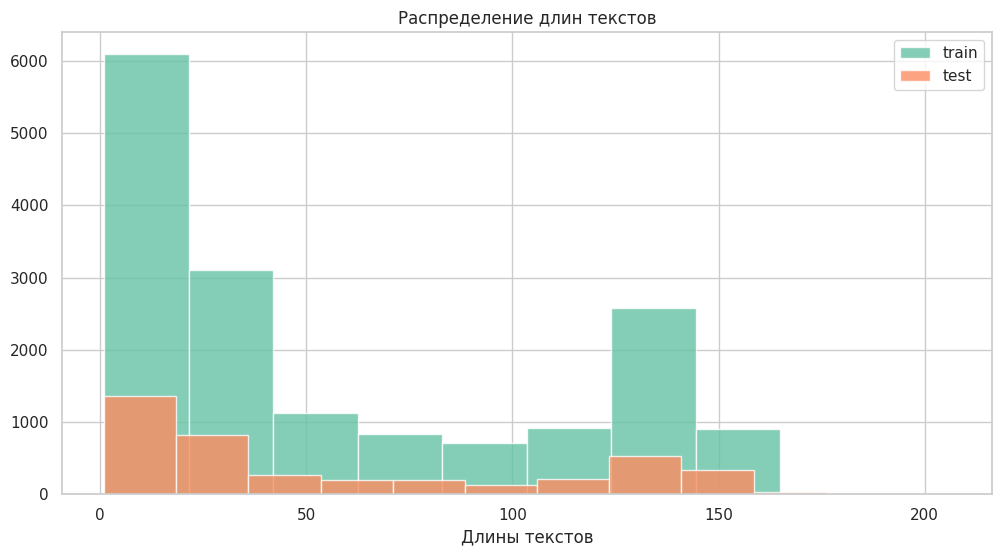

In [9]:
lens_train = [len(text.split()) for text in df_train['text']]
lens_test = [len(text.split()) for text in df_test['text']]
plt.figure(figsize = (12, 6))
plt.title('Распределение длин текстов')
plt.hist(lens_train, alpha=0.8, label='train')
plt.hist(lens_test, alpha=0.8, label='test')
plt.legend()
plt.xlabel('Длины текстов')
plt.show()

Видно, что тексты кроткие. В трейне и тесте одинаковые распределения

Посмотрим на долю спама

In [10]:
spam = df_train['text_type'].mean()
ham = 1 - spam
print('Доля спама:', spam.round(3))
print('Доля не спама:', ham.round(3))

Доля спама: 0.295
Доля не спама: 0.705


Есть сдвиг в сторону не спам сообщений

# Модель

Возьмем модель предобученную на задачу классификации спама. Она училась на очень похожих датасетах

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('mshenoda/roberta-spam', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('mshenoda/roberta-spam')

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [12]:
train_target = df_train['text_type']
train_text = df_train['text']

Разобьем данные на трей и валидацию

In [13]:
train_data, val_data, train_labels, val_labels = train_test_split(train_text, 
                                                                  train_target, 
                                                                  test_size=0.2)

Зададим датасеты

In [14]:
train_dataset = Dataset.from_dict({
    "text": list(train_data),  
    "labels": list(train_labels)       
})

val_dataset = Dataset.from_dict({
    "text": list(val_data),
    "labels": list(val_labels)
})

Токенизируем тексты

In [15]:
train_dataset = train_dataset.map(
    lambda elem: tokenizer(
        elem["text"],             
        add_special_tokens=True,  
        truncation=True,          
        max_length=256            
    )
)

val_dataset = val_dataset.map(
    lambda elem: tokenizer(
        elem["text"],
        add_special_tokens=True,
        truncation=True,
        max_length=256
    )
)

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

Удалим сами тексты

In [16]:
train_dataset = train_dataset.remove_columns("text")
val_dataset = val_dataset.remove_columns("text")

Функция для подсчета метрик. F-score отображаю для себя

In [17]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=1)
    return {
        "ROC-AUC-score": roc_auc_score(labels, logits[:, 1]),
        "F1-score": f1_score(labels, preds)
    }

Учить будем только классификатор

In [18]:
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

Зададим параметры обучения. Достаточно будет одной эпохи, т.к. модель предобучена на очень похожем датасете. Да и по метрикам будет видно, что эпохи достаточно

In [19]:
batch_size = 512
num_epochs = 1

In [20]:
data_collator = DataCollatorWithPadding(tokenizer)

In [21]:
args = TrainingArguments(
    f"roberta_spam",               
    evaluation_strategy="epoch",                
    save_strategy="epoch",                      
    learning_rate=3e-4,                         
    per_device_train_batch_size=batch_size,     
    per_device_eval_batch_size=batch_size,      
    num_train_epochs=num_epochs,                
    weight_decay=0.01,                          
    load_best_model_at_end=True,                
    report_to="none",
    logging_dir='./logging',
    logging_steps=10
)

Запускаем обучение

In [22]:
trainer = Trainer(
    model,                              
    args,                               
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,           
    data_collator=data_collator,        
    tokenizer=tokenizer,                
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Roc-auc-score,F1-score
1,0.025900,0.014943,0.999671,0.994618


TrainOutput(global_step=26, training_loss=0.03137235744641377, metrics={'train_runtime': 136.0403, 'train_samples_per_second': 95.722, 'train_steps_per_second': 0.191, 'total_flos': 1713116081448960.0, 'train_loss': 0.03137235744641377, 'epoch': 1.0})

# Инференс

Зададим датасет для инференса модели

In [23]:
test_dataset = Dataset.from_dict({
    "text": list(df_test['text']),
})

In [24]:
test_dataset = test_dataset.map(
    lambda elem: tokenizer(
        elem["text"],
        add_special_tokens=True,
        truncation=True,
        max_length=256
    )
)

Map:   0%|          | 0/4070 [00:00<?, ? examples/s]

In [25]:
test_dataset = test_dataset.remove_columns("text")

Зададим даталоадер, чтобы батчами делать предикты

In [26]:
test_loader = DataLoader(test_dataset, 
                          batch_size=512,
                          shuffle=False,
                          collate_fn=data_collator)

Делаем предикты

In [27]:
predictions = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        logits = model(input_ids=input_ids, attention_mask=attention_mask)['logits']
        preds = list(np.argmax(logits.cpu().numpy(), axis=1))
        predictions += preds

Сформируем итоговую таблицу

In [28]:
df_test['text_type'] = predictions

In [29]:
df_final = pd.DataFrame([df_test['text_type'], df_test['text']]).T

In [30]:
ids2label = {
    0 : 'ham',
    1 : 'spam'
}

In [31]:
df_final['text_type'] = df_final['text_type'].map(ids2label)

In [32]:
df_final.head()

,text_type,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,spam,underpriced issue with high return on equity t...


Сохраним результат

In [33]:
df_final.to_csv('test.csv')